# Predictive Uncertainty Estimation using Deep Ensemble (Regression)

## Dataset: Toy Dataset

This algorithm is implementation of paper [Simple and Scalable Predictive Uncertainty Estimation using Deep Ensembles](https://arxiv.org/abs/1612.01474). In this jupyter notebook, I will implement regression part of this paper using 1D Toy Dataset (x^3 + epsilon where epsilon ~ N(0, 3^2))

## Import Modules

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

## Parameters

In [12]:
# Parameters of training
Learning_rate = 0.0001
epsilon = 1e-8

num_iter = 5000
batch_size = 256

test_ratio = 0.1
gpu_fraction = 0.2

# Ensemble networks (5 networks)
networks = ['network1', 'network2', 'network3', 'network4', 'network5']

# Dense [input size, output size]
dense1 = [1, 256]
dense2 = [256, 512]
dense_mu  = [512, 1]
dense_sig = [512, 1]

## Making Toy Dataset 

Train data shape: (1080, 1)
Test data shape: (121, 1)


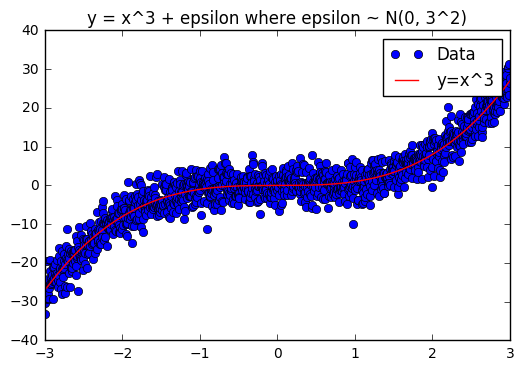

In [13]:
data_range = 3
data_step = 0.005
data_sigma = 3 
num_data = 1

data_x = np.arange(-data_range, data_range + data_step, data_step)
data_x = np.reshape(data_x, [data_x.shape[0], 1])

data_y = np.zeros([data_x.shape[0], 1])
data_y_true = np.zeros([data_x.shape[0], 1])

for i in range(data_x.shape[0]):
    data_y[i, 0] = (data_x[i,0] ** 3) + np.random.normal(0, data_sigma)
    data_y_true[i, 0] = (data_x[i,0] ** 3)
    
num_train_data = int(data_x.shape[0] * (1 - test_ratio))
num_test_data  = data_x.shape[0] - num_train_data

train_x = data_x[:num_train_data, :]
train_y = data_y[:num_train_data, :]
test_x  = data_x[num_train_data:, :]
test_y  = data_y[num_train_data:, :]

print("Train data shape: " + str(train_x.shape))
print("Test data shape: " + str(test_x.shape))

plt.plot(data_x, data_y, 'bo')
plt.plot(data_x, data_y_true, 'r')
plt.legend(['Data', 'y=x^3'])
plt.title('y = x^3 + epsilon where epsilon ~ N(0, 3^2)')
plt.show()

## Functions

In [21]:
tf.reset_default_graph()

def weight_variable(name, shape):
    return tf.get_variable(name, shape = shape, initializer = tf.contrib.layers.xavier_initializer(), dtype = tf.float64)

def bias_variable(name, shape):
    return tf.get_variable(name, shape = shape, initializer = tf.contrib.layers.xavier_initializer(), dtype = tf.float64)

# Get networks
def get_network(network_name):
    input_x = tf.placeholder(tf.float64, shape = [None, 1])
    
    with tf.variable_scope(network_name):
        # Densely connect layer variables
        w_fc1 = weight_variable(network_name + '_w_fc1', dense1)
        b_fc1 = bias_variable(network_name + '_b_fc1', [dense1[1]])
        
        w_fc2 = weight_variable(network_name + '_w_fc2', dense2)
        b_fc2 = bias_variable(network_name + '_b_fc2', [dense2[1]])
        
        w_fc_mu = weight_variable(network_name + '_w_fc_mu', dense_mu)
        b_fc_mu = bias_variable(network_name + '_b_fc_mu', [dense_mu[1]])

        w_fc_sig = weight_variable(network_name + '_w_fc_sig', dense_sig)
        b_fc_sig = bias_variable(network_name + '_b_fc_sig', [dense_sig[1]])

    # Network
    fc1 = tf.nn.relu(tf.matmul(input_x, w_fc1) + b_fc1)
    fc2 = tf.nn.relu(tf.matmul(fc1, w_fc2) + b_fc2)
    output_mu  = tf.matmul(fc2, w_fc_mu) + b_fc_mu
    output_sig = tf.matmul(fc2, w_fc_sig) + b_fc_sig
    output_sig_pos = tf.log(1 + tf.exp(output_sig)) + 1e-06
    
    y = tf.placeholder(tf.float64, shape = [None, 1])
    
    # Negative Log Likelihood(NLL) 
    loss = tf.reduce_mean(0.5*tf.log(output_sig_pos) + 0.5*tf.div(tf.square(y - output_mu),output_sig_pos)) + 10

    # Get trainable variables
    train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, network_name) 
    
    # Gradient clipping for preventing nan
    optimizer = tf.train.AdamOptimizer(learning_rate = Learning_rate)
    gvs = optimizer.compute_gradients(loss, var_list = train_vars)
    capped_gvs = [(tf.clip_by_value(grad, -1., 1.), var) for grad, var in gvs]
    train_opt = optimizer.apply_gradients(capped_gvs)

    return input_x, y, output_mu, output_sig_pos, loss, train_opt, train_vars


# Make batch data 
def making_batch(data_size, sample_size, data_x, data_y):
    
    # Making batches(testing)
    batch_idx = np.random.choice(data_size, sample_size)
    
    batch_x = np.zeros([sample_size, num_data])
    batch_y = np.zeros([sample_size, 1])
        
    for i in range(batch_idx.shape[0]):
        batch_x[i,:] = data_x[batch_idx[i], :]
        batch_y[i,:] = data_y[batch_idx[i], :] 
        
    return batch_x, batch_y   

## Initialize Ensemble Networks

In [22]:
x_list = []
y_list = []
output_mu_list = []
output_sig_list = []
loss_list = []
train_list = []
train_var_list = []
output_test_list = []

# Train each ensemble network
for i in range(len(networks)):
    x_input, y, output_mu, output_sig, loss, train_opt, train_vars = get_network(networks[i])

    x_list.append(x_input)
    y_list.append(y)
    output_mu_list.append(output_mu)
    output_sig_list.append(output_sig)
    loss_list.append(loss)
    train_list.append(train_opt)
    train_var_list.append(train_vars)


## Create Session

In [23]:
# Create Session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = gpu_fraction

sess = tf.InteractiveSession(config=config)
sess.run(tf.global_variables_initializer())

## Training

In [24]:
# Set parameters for printing and testing
num_print = 100
test_size = 10

train_data_num = train_x.shape[0]
test_data_num  = test_x.shape[0]

loss_train = np.zeros([len(networks)])
out_mu     = np.zeros([test_size, len(networks)])
out_sig    = np.zeros([test_size, len(networks)])

for iter in range(num_iter):
    # Making batches(testing)
    batch_x_test, batch_y_test = making_batch(test_data_num, test_size, test_x, test_y)
        
    for i in range(len(networks)):
        # Making batches(training)
        batch_x, batch_y = making_batch(train_data_num, batch_size, train_x, train_y)
       
        # Training
        _, loss, mu, sig = sess.run([train_list[i], loss_list[i], output_mu_list[i], output_sig_list[i]], 
                                     feed_dict = {x_list[i]: batch_x, y_list[i]: batch_y})
  
      
        # Testing
        loss_test, mu_test, sig_test = sess.run([loss_list[i], output_mu_list[i], output_sig_list[i]], 
                                                feed_dict = {x_list[i]: batch_x_test, y_list[i]: batch_y_test})

        if np.any(np.isnan(loss)):
            raise ValueError('There is Nan in loss')
        
        loss_train[i] += loss
        out_mu[:, i] = np.reshape(mu_test, (test_size))
        out_sig[:, i] = np.reshape(sig_test, (test_size))
        
    # Get final test result
    out_mu_final = np.mean(out_mu, axis = 1)
    out_sig_final = np.sqrt(np.mean(out_sig + np.square(out_mu), axis = 1) - np.square(out_mu_final))
    
    if iter % num_print == 0 and iter != 0:
        print(('-------------------------') + ' Iteration: ' + str(iter) + ' -------------------------')
        print('Average Loss(NLL): ' + str(loss_train / num_print))
        print('mu: ' + str(out_mu[0, :]))
        print('std: ' + str(np.sqrt(out_sig[0, :])))
        print('Final mu: ' + str(out_mu_final[0]))
        print('Final std: ' + str(out_sig_final[0]))
        print('Real Value: ' + str(batch_y_test[0]))
        print('\n')
        
        loss_train = np.zeros(len(networks))


------------------------- Iteration: 100 -------------------------
Average Loss(NLL): [ 71.38958948  61.76199502  80.00736702  39.65547508  25.47398658]
mu: [ 0.94101925 -0.76019779  0.03170051  1.89894142  2.47524328]
std: [ 1.33556844  1.52343535  1.38030615  1.66914274  2.27568284]
Final mu: 0.917341334676
Final std: 2.04764588326
Real Value: [ 16.03446811]


------------------------- Iteration: 200 -------------------------
Average Loss(NLL): [ 24.25253256  23.56765285  25.45299655  19.93209531  16.75974374]
mu: [ 1.23596952  0.0818743   0.61054604  2.11314312  4.03982719]
std: [ 2.05405971  2.27681457  2.1450215   2.35867207  2.82498974]
Final mu: 1.61627203357
Final std: 2.72686837915
Real Value: [ 21.07163254]


------------------------- Iteration: 300 -------------------------
Average Loss(NLL): [ 17.78189178  17.52992846  18.40788524  15.63816703  14.03471598]
mu: [ 1.64616621  1.01871391  1.20123188  2.6922971   5.87979822]
std: [ 2.47995859  2.70775528  2.59154607  2.7454326

## Testing with Known and Unknown Data

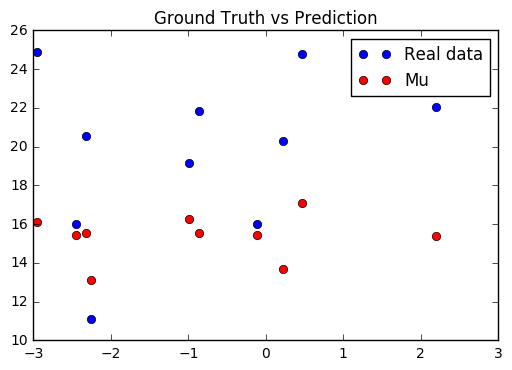

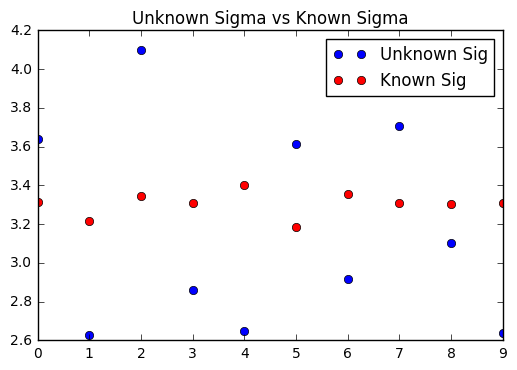

In [20]:
# Get Unknown dataset and test 
x_sample = np.random.uniform(-3, 3, size = (test_size,num_data))

out_mu_sample  = np.zeros([test_size, len(networks)])
out_sig_sample = np.zeros([test_size, len(networks)])

for i in range(len(networks)):
    mu_sample, sig_sample = sess.run([output_mu_list[i], output_sig_list[i]], 
                                      feed_dict = {x_list[i]: x_sample})

    out_mu_sample[:,i]  = np.reshape(mu_sample, (test_size))
    out_sig_sample[:,i] = np.reshape(sig_sample, (test_size))

out_mu_sample_final  = np.mean(out_mu_sample, axis = 1)
out_sig_sample_final = np.sqrt(np.mean(out_sig_sample + np.square(out_mu_sample), axis = 1) - np.square(out_mu_sample_final))

# Plot mean and variable vs real data 
plt.figure(1)
plt.hold
plt.plot(x_sample, batch_y_test, 'bo')
plt.plot(x_sample, out_mu_final, 'ro')
plt.legend(['Real data', 'Mu'], loc = 'best')
plt.title('Ground Truth vs Prediction')

# Plot comparison of known sig and unknown sig
plt.figure(2)
plt.hold
plt.plot(out_sig_sample_final, 'bo')
plt.plot(out_sig_final, 'ro')
plt.legend(['Unknown Sig', 'Known Sig'], loc = 'best')
plt.title('Unknown Sigma vs Known Sigma')

plt.show()